[参考ページ](https://github.com/takitsuba/midoribon/blob/master/Chap6/Chap6.ipynb)

In [1]:
import seaborn as sns; sns.set(font="IPAexGothic")
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
print(sns.__version__)

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

np.random.seed(1000)

d = pd.read_csv("data4a.csv",dtype={"y": int,"x":float, "f":"category"})

0.9.0


In [2]:
d.head()

,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


In [3]:
#観測数N y生存数 x体サイズ f肥料

In [4]:
d.describe()

,N,y,x
count,100.0,100.000000,100.000000
mean,8.0,5.080000,9.967200
std,0.0,2.743882,1.088954
min,8.0,0.000000,7.660000
25%,8.0,3.000000,9.337500
50%,8.0,6.000000,9.965000
75%,8.0,8.000000,10.770000
max,8.0,8.000000,12.440000


In [5]:
d.f.describe()

count     100
unique      2
top         T
freq       50
Name: f, dtype: object

In [6]:
d.f

0     C
1     C
2     C
3     C
4     C
     ..
95    T
96    T
97    T
98    T
99    T
Name: f, Length: 100, dtype: category
Categories (2, object): [C, T]

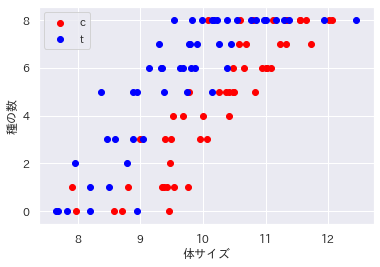

In [7]:
x_c = d.x[d.f == "C"]
y_c = d.y[d.f == "C"]

x_t = d.x[d.f == "T"]
y_t = d.y[d.f == "T"]

plt.scatter(x_c,y_c,c="red",label="c")
plt.scatter(x_t,y_t,c="blue",label="t")
plt.ylabel('種の数')
plt.xlabel('体サイズ')
plt.legend()
plt.show()

体サイズ$x_i$が大きくなると、生存種子数$y_i$は多くなりそうだ  
肥料をやる（$f_i = T$)と、生存種子数$y_i$は多くなりそうだ

# ロジスティクス回帰

In [8]:
model = smf.glm('y + I(N-y)~ x + f',data=d,family=sm.families.Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -133.11
Date:                Wed, 18 Sep 2019   Deviance:                       123.03
Time:                        14:11:09   Pearson chi2:                     109.
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.5361      1.414    -13.818      0.000     -22.307     -16.765
f[T.T]         2.0215      0.231      8.740      0.000       1.568       2.475
x              1.9524      0.139     14.059      0.000       1.680       2.225
==============================================================================
"""

# stan 

url(https://www.slideshare.net/simizu706/stan-64926504)
参考になるかも

In [9]:
dstan = d.copy()
#肥料のカテゴリを0,1に変換
dstan = dstan.replace('C',int(0))
dstan = dstan.replace('T',int(1))
dstan.describe()

,N,y,x,f
count,100.0,100.000000,100.000000,100.000000
mean,8.0,5.080000,9.967200,0.500000
std,0.0,2.743882,1.088954,0.502519
min,8.0,0.000000,7.660000,0.000000
25%,8.0,3.000000,9.337500,0.000000
50%,8.0,6.000000,9.965000,0.500000
75%,8.0,8.000000,10.770000,1.000000
max,8.0,8.000000,12.440000,1.000000


In [13]:
# PyStan用のコードを使ってy = β0 + β1x + β2f のモデルを定義
import pystan
model1 = """
   data {
       int<lower=0> J;
       int<lower=0> N[J];
       int<lower=0> y[J];
       real<lower=0> x[J];
       real<lower=0> f[J];
   }
   parameters {
       real beta_0;
       real beta_1x;
       real beta_2f;
   }
   model {
       beta_0 ~ normal(0, 100);
       beta_1x ~ normal(0, 100);
       beta_2f ~ normal(0, 100);
       for (i in 1:J) {
           y[i] ~ binomial(N[i], inv_logit(beta_0 + beta_1x * x[i] + beta_2f * f[i]));
       }
   }
   """
#y[i] ~ binomial(8, inv_logit(beta_0 + beta_1 * x[i] + beta_2 * f[i]));
#8個とってみてどうなったか

In [14]:
#使用データ
dat = {'J': dstan.shape[0],
       'N': dstan['N'],
       'x': dstan['x'],
       'f': dstan['f'],
       'y': dstan['y']}

#モデル作成
%time model1 = pystan.StanModel(model_code=model1)
#サンプリング実行
%time fit = model1.sampling(data=dat)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_189d13ed549021d856f023de49f32bed NOW.


Wall time: 1min 7s
Wall time: 5.99 s


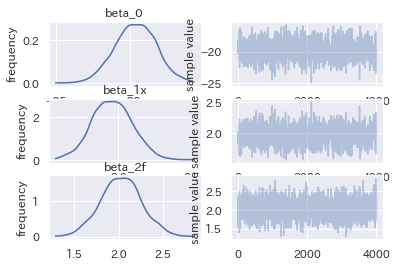

<Figure size 1080x1080 with 0 Axes>

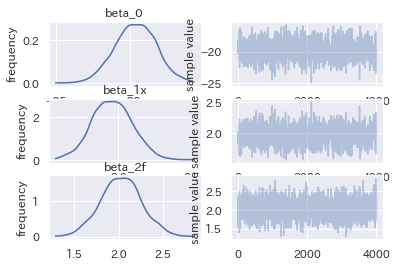

In [23]:
plt.figure(figsize=(15,15))
fit.plot()

In [16]:
fit

Inference for Stan model: anon_model_189d13ed549021d856f023de49f32bed.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_0  -19.61    0.05   1.38 -22.33 -20.54  -19.6 -18.65 -16.84    828    1.0
beta_1x   1.96  4.7e-3   0.14   1.69   1.87   1.96   2.05   2.23    849    1.0
beta_2f   2.03  7.0e-3   0.23   1.57   1.88   2.03   2.18   2.49   1086    1.0
lp__    -338.3    0.03   1.17 -341.3 -338.9 -338.0 -337.5 -337.0   1159    1.0

Samples were drawn using NUTS at Wed Sep 18 14:12:43 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


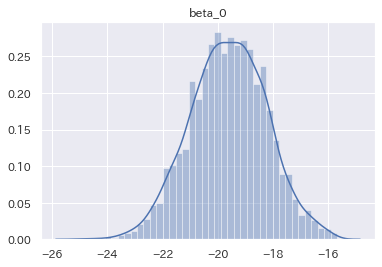

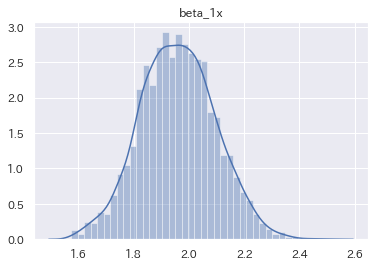

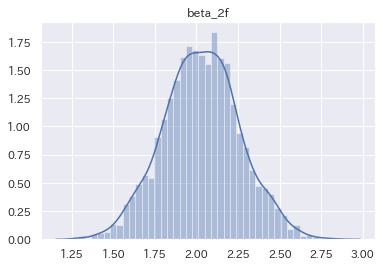

In [29]:
beta = ['beta_0','beta_1x','beta_2f']
for i in range(len(beta)):
    b = beta[i]
    sns.distplot(fit[b])
    plt.title(b)
    plt.show()

In [17]:
#比較のためglmの結果をここに貼り付け
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -133.11
Date:                Wed, 18 Sep 2019   Deviance:                       123.03
Time:                        14:12:46   Pearson chi2:                     109.
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.5361      1.414    -13.818      0.000     -22.307     -16.765
f[T.T]         2.0215      0.231      8.740      0.000       1.568       2.475
x              1.9524      0.139     14.059      0.000       1.680       2.225
==============================================================================
"""

In [18]:
%%html
<style>
table {float:left}
</style>

glm

| 　 | coef | std |
|---|:---:|---:|
|x|1.9524|0.139|
|f|2.02|0.232|
|b|-19.53|1.414|



stan

| 　 | coef | std |
|---|:---:|---:|
|x|0.05|0.55|
|f|0.24|0.14|
|b|0.34|1.53|
